In [5]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import csr_matrix, hstack

# Load the dataset
df = pd.read_csv('diabetic_data_o.csv')

# Display the first few rows of the dataframe
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
# Replace '?' with NaN for imputation and drop 'weight' due to high missing values
df.replace('?', np.nan, inplace=True)
df.drop('weight', axis=1, inplace=True)

In [7]:
# Impute missing values with 'unknown' for selected categorical columns
categorical_columns_with_nans = ['race', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']
for column in categorical_columns_with_nans:
    df[column].fillna('unknown', inplace=True)
features_to_use = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
data_for_clustering = df[features_to_use]

In [8]:
# One-hot encoding for a subset of categorical variables with sparse matrix
encoder_sparse = OneHotEncoder(sparse=True, drop='first')
categorical_columns_subset = ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
encoded_columns_sparse = encoder_sparse.fit_transform(df[categorical_columns_subset])


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
# Selecting numerical columns and converting to sparse matrix
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_data = df[numerical_columns]
numerical_data_sparse = csr_matrix(numerical_data)


In [10]:
# Combining sparse matrices for features
X_sparse = hstack([numerical_data_sparse, encoded_columns_sparse])

# Encoding the target variable as binary
y = (df['readmitted'] != 'NO').astype(int)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

# Initializing and training the logistic regression model
model = LogisticRegression(max_iter=1000, solver='saga')
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [11]:

# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.5666699420261374
Precision: 0.5505559416261293
Recall: 0.3370559455435014
F1 Score: 0.41812904077055024


In [12]:
# K-Means Clustering for pattern discovery
# Preparing data for clustering (using a subset of features for simplicity)
features_for_clustering = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
data_for_clustering = df[features_for_clustering]

In [13]:
# Standardizing features for clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)


In [14]:
# Applying K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Example: 3 clusters
clusters = kmeans.fit_predict(data_scaled)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [15]:
# Adding cluster information to the dataframe
df['Cluster'] = clusters

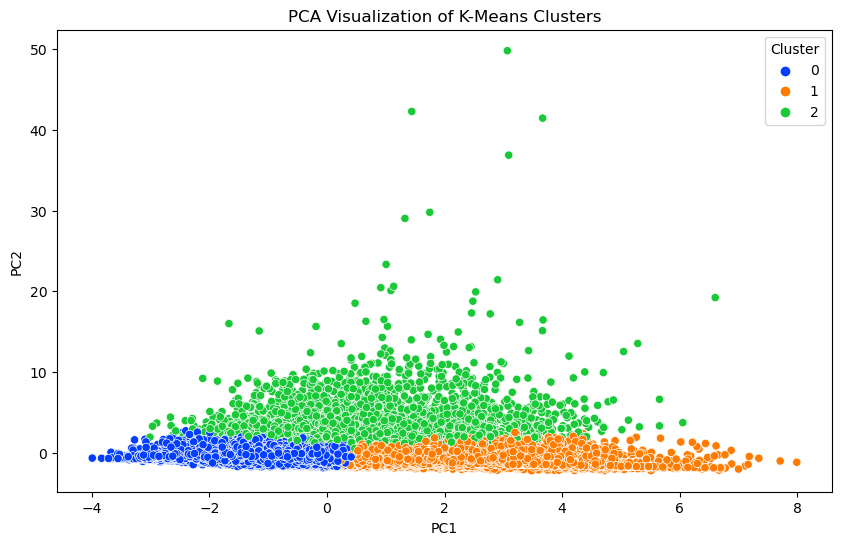

In [16]:
# Visualizing clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['Cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=principal_df, palette='bright')
plt.title('PCA Visualization of K-Means Clusters')
plt.show()

In [17]:
#For simplicity, let's assume we use logistic regression as both the global model and for each local classifier. We'll use the clusters obtained from the K-Means algorithm as our segmentation basis.
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
# Assume 'readmitted' is the target variable for logistic regression models
y = (df['readmitted'] != 'NO').astype(int)

# Define preprocessing for numerical and categorical features
categorical_features = ['race', 'gender', 'age']  # Example categorical features
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']  # Example numerical features

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ])





In [18]:
# Apply preprocessing
X = df[categorical_features + numerical_features]
X_processed = preprocessor.fit_transform(X)



# Splitting the processed data for a global model (optional)
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Global logistic regression model (for comparison)
global_lr_model = LogisticRegression(max_iter=1000)
global_lr_model.fit(X_train_global, y_train_global)
y_pred_global = global_lr_model.predict(X_test_global)
print("Global Model Performance:")
print(f"Accuracy: {accuracy_score(y_test_global, y_pred_global)}")



Global Model Performance:
Accuracy: 0.548049523435197


In [19]:
# Build local classifiers based on clusters
for cluster in df['Cluster'].unique():
    cluster_mask = df['Cluster'] == cluster
    X_cluster = X_processed[cluster_mask]
    y_cluster = y[cluster_mask]

    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)

    print(f"\nCluster {cluster} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")


Cluster 0 Model Performance:
Accuracy: 0.591461941200161
Precision: 0.5069582504970179
Recall: 0.10027526543452615
F1 Score: 0.1674326986211425

Cluster 1 Model Performance:
Accuracy: 0.5311331490814502
Precision: 0.5285610990600145
Recall: 0.24670941613229835
F1 Score: 0.3364012885411873

Cluster 2 Model Performance:
Accuracy: 0.7372833985466741
Precision: 0.7372833985466741
Recall: 1.0
F1 Score: 0.8487773487773488


In [23]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming the dataset is already loaded, preprocessed, and clusters are defined in 'df['Cluster']'

# Initialize SMOTE
smote = SMOTE(random_state=42)

unique_clusters = df['Cluster'].unique()
local_classifiers_balanced = {}
performance_metrics_balanced = {}

# Iterate over each cluster to train a balanced logistic regression model
for cluster in unique_clusters:
    print(f"\n--- Cluster {cluster} ---")
    # Select data corresponding to the current cluster
    cluster_mask = df['Cluster'] == cluster
    X_cluster = X_sparse[cluster_mask].toarray()  # Convert to dense array for SMOTE
    y_cluster = y[cluster_mask]
    
    # Balance the dataset using SMOTE
    X_balanced, y_balanced = smote.fit_resample(X_cluster, y_cluster)
    
    # Split the balanced dataset
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    
    # Train logistic regression model on the balanced dataset
    lr_model_balanced = LogisticRegression(max_iter=1000, solver='saga')
    lr_model_balanced.fit(X_train, y_train)
    local_classifiers_balanced[cluster] = lr_model_balanced

# Evaluate the balanced model
    y_pred_balanced = lr_model_balanced.predict(X_test)
    accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
    precision_balanced = precision_score(y_test, y_pred_balanced)
    recall_balanced = recall_score(y_test, y_pred_balanced)
    f1_balanced = f1_score(y_test, y_pred_balanced)
    
    performance_metrics_balanced[cluster] = {
        'accuracy': accuracy_balanced,
        'precision': precision_balanced,
        'recall': recall_balanced,
        'f1': f1_balanced
    }
    
    print(f"Balanced Model Performance Metrics for Cluster {cluster}:")
    print(f"Accuracy: {accuracy_balanced:.4f}, Precision: {precision_balanced:.4f}, Recall: {recall_balanced:.4f}, F1 Score: {f1_balanced:.4f}")

    
    




--- Cluster 0 ---
Balanced Model Performance Metrics for Cluster 0:
Accuracy: 0.5622, Precision: 0.5790, Recall: 0.4857, F1 Score: 0.5283

--- Cluster 1 ---
Balanced Model Performance Metrics for Cluster 1:
Accuracy: 0.5497, Precision: 0.5579, Recall: 0.4807, F1 Score: 0.5164

--- Cluster 2 ---
Balanced Model Performance Metrics for Cluster 2:
Accuracy: 0.5516, Precision: 0.5591, Recall: 0.5072, F1 Score: 0.5319
